In [ ]:
%matplotlib nbagg

In [ ]:
import numpy as np
import matplotlib.pylab as plt
from astropy.coordinates import CartesianRepresentation, CartesianDifferential, ICRS
import astropy.units as u

def spherical_to_cartesian(r,theta,phi):
    '''
        Turns a spherical cooridinate into a cartesian coordinate. 
   
    parameters
    -----------
        r, theta, phi: floats. 
    
        returns 
        ---------
        x, y, z: floats
    '''
    x = r*np.sin(theta)*np.cos(phi)
    y = r*np.sin(theta)*np.sin(phi)
    z = r*np.cos(theta)
    return(x,y,z)

def generate_n_random_lines_of_sight(num_los):
    '''
    helper function
    
    Generates n sets of 3 orthonormal vectors of unit length, with the z-axes
    distributed randomly over the unit sphere.
    
    parameters
    ----------
    num_los: float. How many vectors to generate
    
    returns:
    --------
    x_axes, y_axes, z_axes: arrays of floats with n rows and 3 colums, each 
    giving x, y, and z coordinates of each vector. Such that X[0], Y[0], Z[0] 
    are orthonormal, etc. 
    '''
    num_los = int(num_los)
    
    
    # Now generate the thetas and phis
    unifs = np.random.uniform(0, 1, num_los)
    thetas = np.arccos(1 - unifs)
    phis = np.random.uniform(0, 2*np.pi, num_los)
    rs = np.ones(num_los)

    # turn these into cartesian unit vectors.
    
    xx, yy, zz = np.vectorize(spherical_to_cartesian)(rs, thetas, phis)
    z_axes = np.array([xx, yy, zz]).T
    
    return z_axes

<IPython.core.display.Javascript object>


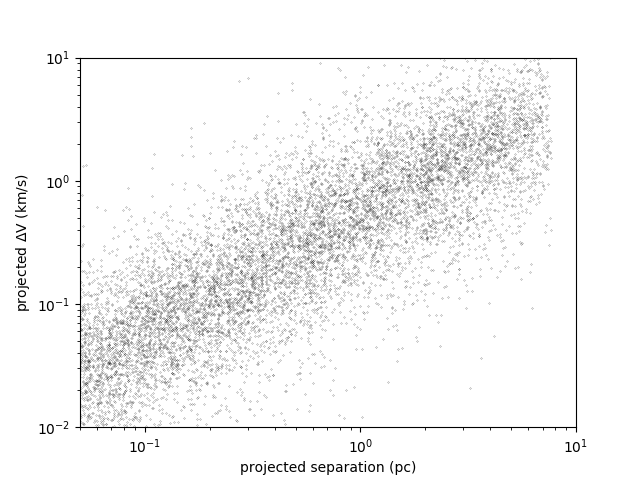

In [8]:
lim = 100 # assume stars are uniformly distributed in space within 100 pc
N = 20000
x = np.random.uniform(-lim, lim, N)
y = np.random.uniform(-lim, lim, N)
z = np.random.uniform(-lim, lim, N)
r = (x*x + y*y + z*z)**(1/2)
m = r < lim 
x, y, z, r = x[m], y[m], z[m], r[m] # throw out stars beyond 100 pc 

# Draw heliocentric velocities for each binary. We draw from a Gaussian with 
# sigma = 30 km/s, which is reasonable for the MW
sigma_v = 30
vx = sigma_v*np.random.randn(len(x))
vy = sigma_v*np.random.randn(len(x))
vz = sigma_v*np.random.randn(len(x))

# draw some intrinsic separations. the distribution is not important, since 
# we are only interested in the typical Delta V at a given separation. 
sep_AU = 10**np.random.uniform(4, 6.2, len(vx))
sep_pc = sep_AU/206265
offset_vecs = generate_n_random_lines_of_sight(len(vx))
off_x, off_y, off_z = offset_vecs.T
dx = off_x * sep_AU
dy = off_y * sep_AU
dz = off_z * sep_AU
# so now sqrt(dx**2 + dy**2 + dz**2) is equal to sep_Au

# assign positions and velocities for the 2nd star. 
x2, y2, z2 = x + dx/206265, y + dy/206265, z + dz/206265
vx2, vy2, vz2 = vx.copy(), vy.copy(), vz.copy() # assume identical 3d velocities 

coord1 = ICRS(x = x*u.pc, y = y*u.pc, z =z*u.pc,
    v_x=vx*u.km/u.s, v_y=vy*u.km/u.s, v_z=vz*u.km/u.s,
    representation_type=CartesianRepresentation,
    differential_type=CartesianDifferential)  

coord2 = ICRS(x = x2*u.pc, y = y2*u.pc, z =z2*u.pc,
    v_x=vx2*u.km/u.s, v_y=vy2*u.km/u.s, v_z=vz2*u.km/u.s,
    representation_type=CartesianRepresentation,
    differential_type=CartesianDifferential)  
    
pmra1, pmdec1 = coord1.proper_motion
pmra2, pmdec2 = coord2.proper_motion
delta_mu = np.sqrt((pmra1 - pmra2)**2 + (pmdec1 - pmdec2)**2).value
parallax = 1000/r
delta_v = 4.74*delta_mu/parallax

X1 = np.vstack([x, y, z]).T
X2 = np.vstack([x2, y2, z2]).T

# get the angular separation theta 
dot_prod = np.einsum('ij,ij->i', X1, X2)
cos_theta = dot_prod/(np.linalg.norm(X1, axis=1) * np.linalg.norm(X2, axis=1))
theta = np.arccos(cos_theta)
theta_arcsec = theta * 206265

# get the projected separation. 
proj_sep = theta*r

plt.loglog(proj_sep, delta_v, 'k.', ms = 0.3)
plt.xlim(0.05, 10)
plt.ylim(0.01, 10)
plt.xlabel('projected separation (pc)')
plt.ylabel(r'projected $\Delta$V (km/s)')

plt.show()